# 1. Imports

In [124]:
import os
import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 2. Downloading data

In [2]:
def download_data(download_url, local_folder_path, file_name):
    os.makedirs(local_folder_path, exist_ok=True)
    urllib.request.urlretrieve(download_url, os.path.join(local_folder_path, file_name))

In [3]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/data/main/housing/housing.csv'
LOCAL_FOLDER = os.getcwd()
NEW_LOCAL_FOLDER = 'datasets'
LOCAL_FOLDER_PATH = os.path.join(LOCAL_FOLDER, NEW_LOCAL_FOLDER)
FILE_NAME = 'housing.csv'

In [4]:
download_data(download_url = DOWNLOAD_ROOT, local_folder_path = LOCAL_FOLDER_PATH, file_name = FILE_NAME)

# 3. Loading data

In [5]:
df_raw = pd.read_csv(os.path.join(NEW_LOCAL_FOLDER, FILE_NAME))
df_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 4. Data description

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 4.1. Categorical variables

In [7]:
cat_atributes = df_raw.select_dtypes(include='object')
cat_atributes.value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
Name: count, dtype: int64

## 4.2. Numerical variables

In [8]:
num_atributes = df_raw.select_dtypes(include='float64')
df_describe = num_atributes.describe().T
df_describe['kurtosis'] = num_atributes.kurtosis()
df_describe['skewness'] = num_atributes.skew()

In [9]:
df_describe

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100,-1.330152,-0.297801
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500,-1.117760,0.465953
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000,-0.800629,0.060331
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000,32.630927,4.147343
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000,21.985575,3.459546
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000,73.553116,4.935858
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000,22.057988,3.410438
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001,4.952524,1.646657
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000,0.327870,0.977763


- Skewness: Medida da assimetria da distribuição normal
    - skew = 0 -> é a distribuição normal
    - skew > 0 -> assimetria com cauda alongada na direção positiva
    - skew < 0 -> assimentra com cauda alongada na direção negativa
- Kurtosis: Medida de quão "pontuda" é a distribuição normal
    - kurtosis > 0 -> mais pontuda
    - kurtosis < 0 -> mais plana

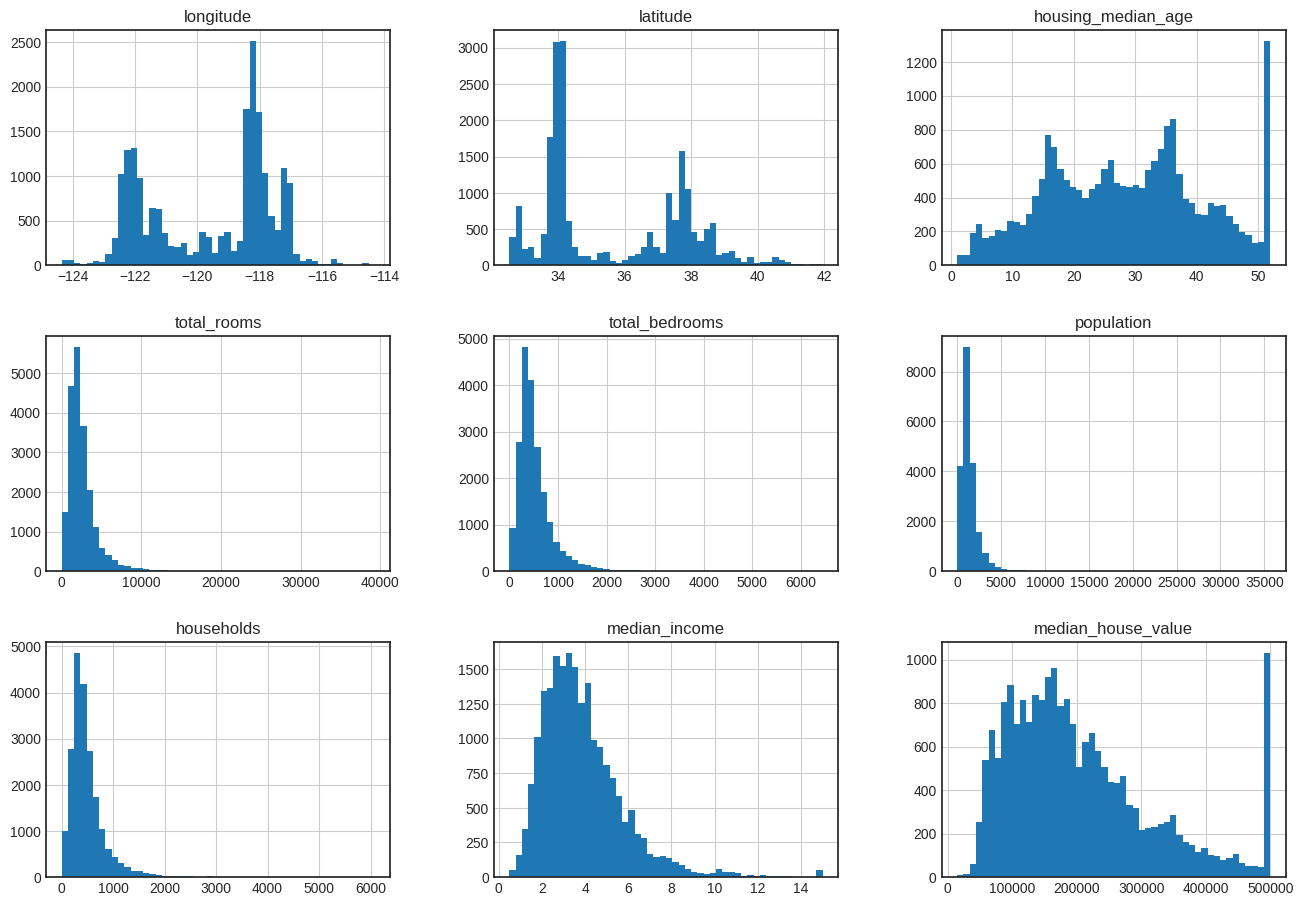

In [10]:
df_raw.hist(bins=50, figsize=(16,11));

# 5. Feature Engineering

## 5.1. Split data into training and testing sets

### 5.1.1. Criando categorias para a renda média
Serve para verificar se a proporção de um atributo muito importante é mantida do cojunto de testes

In [11]:
df_raw['income_cat'] = pd.cut(df_raw['median_income'],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

In [12]:
train_set, test_set = train_test_split(df_raw, train_size=0.8, random_state=42)

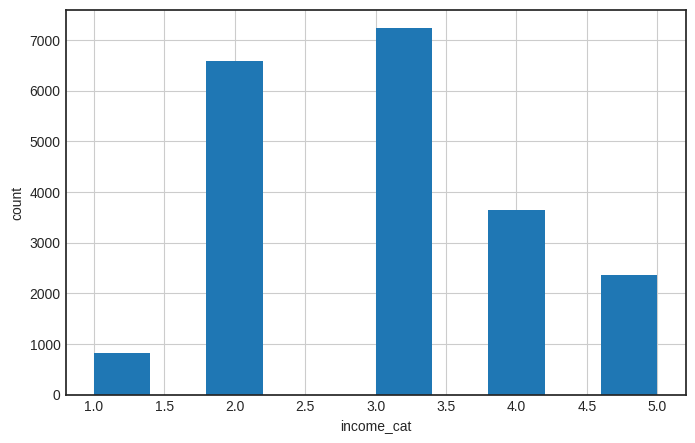

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
#ax.grid(zorder=0)
ax.grid()
#ax.hist(df_raw['income_cat'], zorder=2)
ax.hist(df_raw['income_cat'])
ax.set_xlabel('income_cat')
ax.set_ylabel('count');


### 5.1.2. Amostragem estratificada
- A divisão dos dados é feita mantendo-se a proporcionalidade do atributo desejado

In [14]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [15]:
# Obtenção dos índices dos conjuntos de treino e teste levando em consideração a estratificação de income_cat
for train_index, test_index in split.split(df_raw, df_raw['income_cat']):
    strat_train_set = df_raw.loc[train_index]
    strat_test_set = df_raw.loc[test_index]

In [16]:
# Percentual representativo de cada categoria de salário nos dataframes original, test random e test stratiffied
stratiffied = strat_test_set['income_cat'].value_counts() / len(strat_test_set)
random = test_set['income_cat'].value_counts() / len(test_set)
original = df_raw['income_cat'].value_counts() / len(df_raw)

In [17]:
df_aux = pd.concat([original.rename('original'), random.rename('random'), stratiffied.rename('strat')], axis=1).sort_index()
df_aux
# A divisão entre treino e teste utilizando o StratiffienShuffleSplit preserva mais a representatividade do median_income

,original,random,strat
income_cat,,,
1,0.039826,0.042393,0.039971
2,0.318847,0.307413,0.318798
3,0.350581,0.345203,0.350533
4,0.176308,0.184109,0.176357
5,0.114438,0.120882,0.114341


In [18]:
# Removendo income_cat dos dataframes
for set_ in (df_raw, test_set, train_set, strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# 6. Data exploration

## 6.1. Visualização geográfica

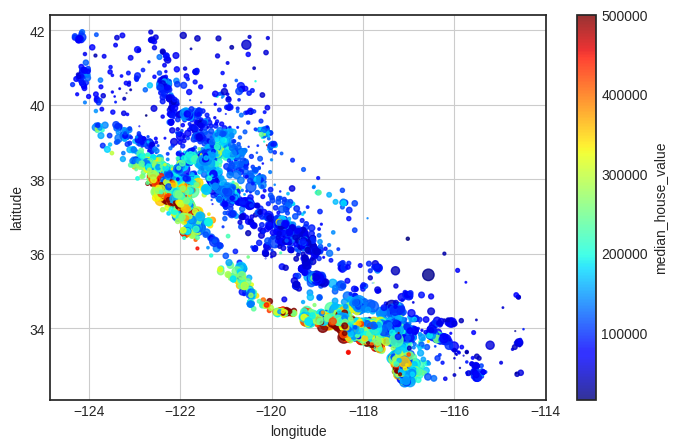

In [19]:
plt.figure(figsize=(8,5))
plt.scatter(x=strat_train_set['longitude'], y=strat_train_set['latitude'],
            alpha=0.8,
            s=strat_train_set['population']/100,
            c=strat_train_set['median_house_value'],
            cmap=plt.get_cmap('jet'))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label='median_house_value')
plt.grid()

## 6.2. Correlation Matrix

In [20]:
corr_matrix = strat_train_set.drop('ocean_proximity', axis=1).corr(method='pearson')

In [21]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [22]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

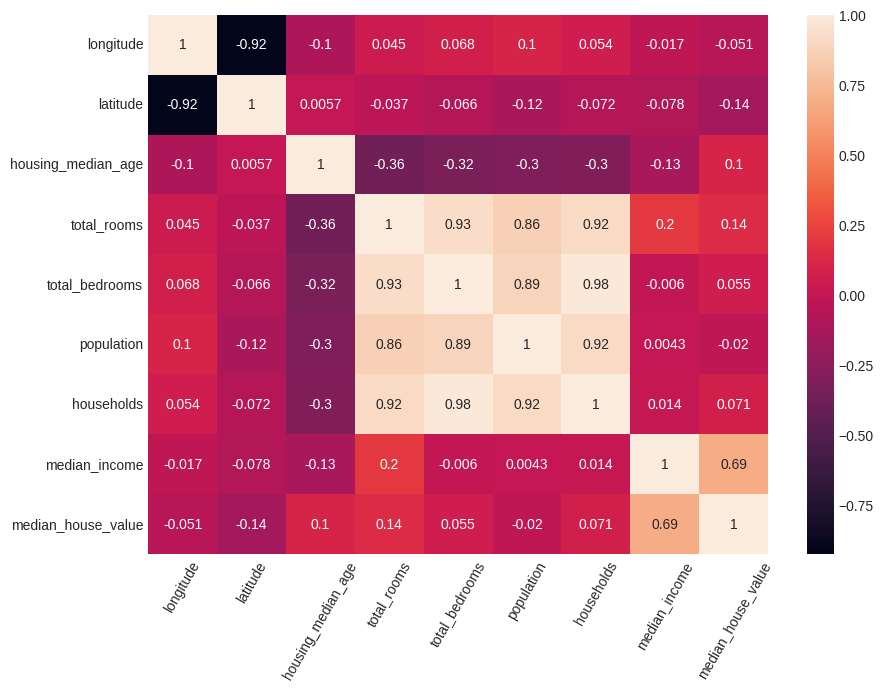

In [23]:
plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=60);

- Baseando-se do heatmap anterior, escolheu-se 3 atributos que possuem a maior correlação com ```median_house_value```
- O gráfico scatter_matrix plota cada um dos atributos numéricos em relação aos outros
- Tendências ascendentes e descendentes, não muito dispersas, representam correlações mais importantes

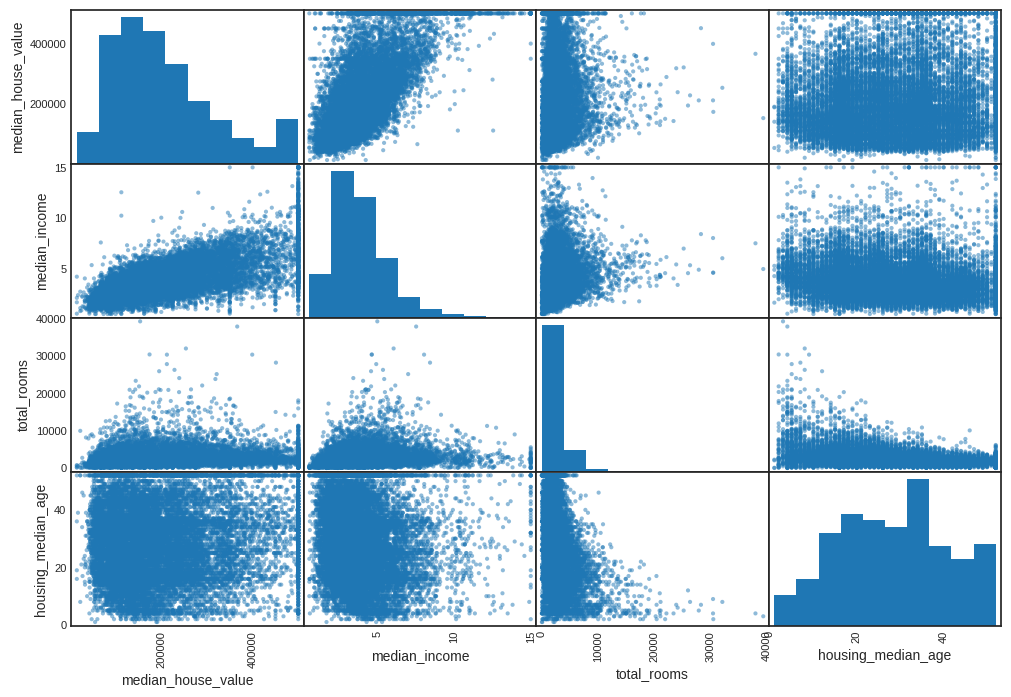

In [24]:
attributes = ['median_house_value','median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(strat_train_set[attributes], figsize=(12,8));

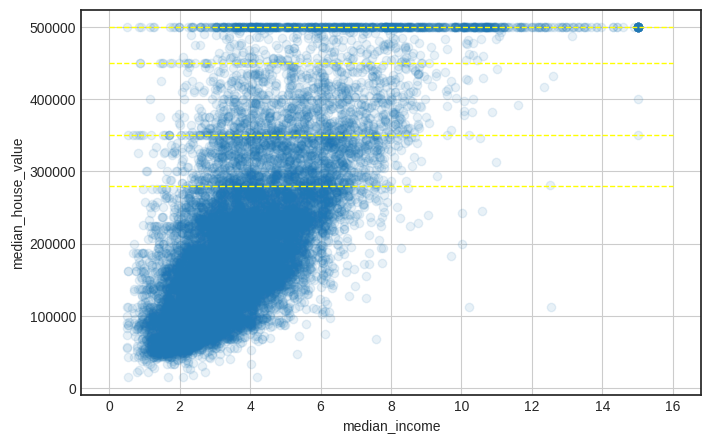

In [25]:
plt.figure(figsize=(8,5))
plt.scatter(x=strat_train_set['median_income'], y=strat_train_set['median_house_value'], alpha=0.1)
plt.hlines(500000, xmin=0, xmax=16, colors='yellow', linestyles='--', linewidth=1)
plt.hlines(450000, xmin=0, xmax=16, colors='yellow', linestyles='--', linewidth=1)
plt.hlines(350000, xmin=0, xmax=16, colors='yellow', linestyles='--', linewidth=1)
plt.hlines(280000, xmin=0, xmax=16, colors='yellow', linestyles='--', linewidth=1)
plt.xlabel('median_income')
plt.ylabel('median_house_value')
plt.grid();

- Percebe-se alguns patamares de valores
- Linhas horizontais em US\$ 500k, US\$ 450k, US\$ 350k e, talvez, em US\$ 280k
- Tal comportamento pode ser prejudicial para o treinamento do modelo pois é um padrão muito peculiar
- Uma alternativa plausível seria retirar dos dados de treino os imóveis com estes valores

# 7. Feature Engineering

In [26]:
housing = strat_train_set.copy()

## 7.1. Limpeza dos dados

In [27]:
# Verificar a existência de dados faltantes e substituir por algum outro. Ex.: média, mediana, moda
# ou utilizando um algorítmo que atribui um valor com base nos vizinhos mais próximos
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [28]:
# Utilizando a média dos valores de total_bedrooms
imputer = SimpleImputer(strategy='mean')

# A média só existe em atributos numéricos, então é necessário retirar a variável categórica
housing_num = housing.drop('ocean_proximity', axis=1)

# Ajustando a instância imputer no dataframe de atributos numéricos
X = imputer.fit_transform(housing_num)

In [29]:
housing_num = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

## 7.2. Criação de novas features
- Cômodos por família (rooms_per_household)
- Quartos por cômodo (bedroom_per_room)
- Habitantes por família (population_per_household)

In [30]:
housing_num['rooms_per_household'] = housing_num['total_rooms'] / housing_num['households']
housing_num['bedroom_per_room'] = housing_num['total_bedrooms'] / housing_num['total_rooms']
housing_num['population_per_household'] = housing_num['population'] / housing_num['households']

In [31]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedroom_per_room,population_per_household
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,3.725256,0.277371,1.631399


### Verificando a correlação das novas features

In [32]:
corr_matrix = housing_num.corr(method='pearson')

In [33]:
corr_matrix['median_house_value']

longitude                  -0.050859
latitude                   -0.139584
housing_median_age          0.102175
total_rooms                 0.137455
total_bedrooms              0.054380
population                 -0.020153
households                  0.071426
median_income               0.688380
median_house_value          1.000000
rooms_per_household         0.143663
bedroom_per_room           -0.214705
population_per_household   -0.038224
Name: median_house_value, dtype: float64

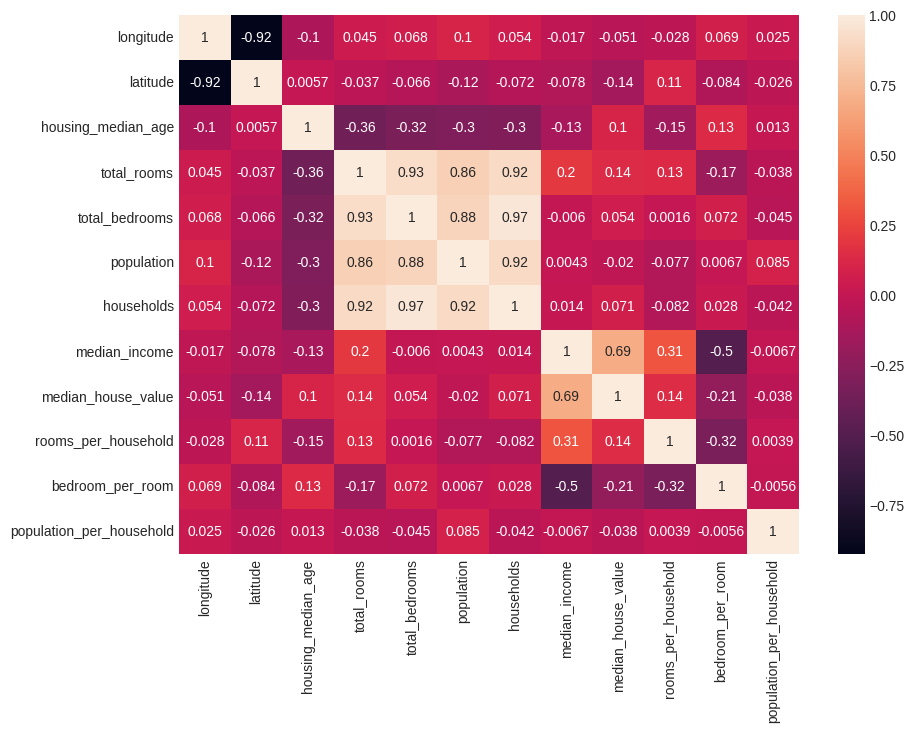

In [34]:
plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True);

- bedroom_per_room apresenta uma correlação com o preço um pouco maior do que total_rooms

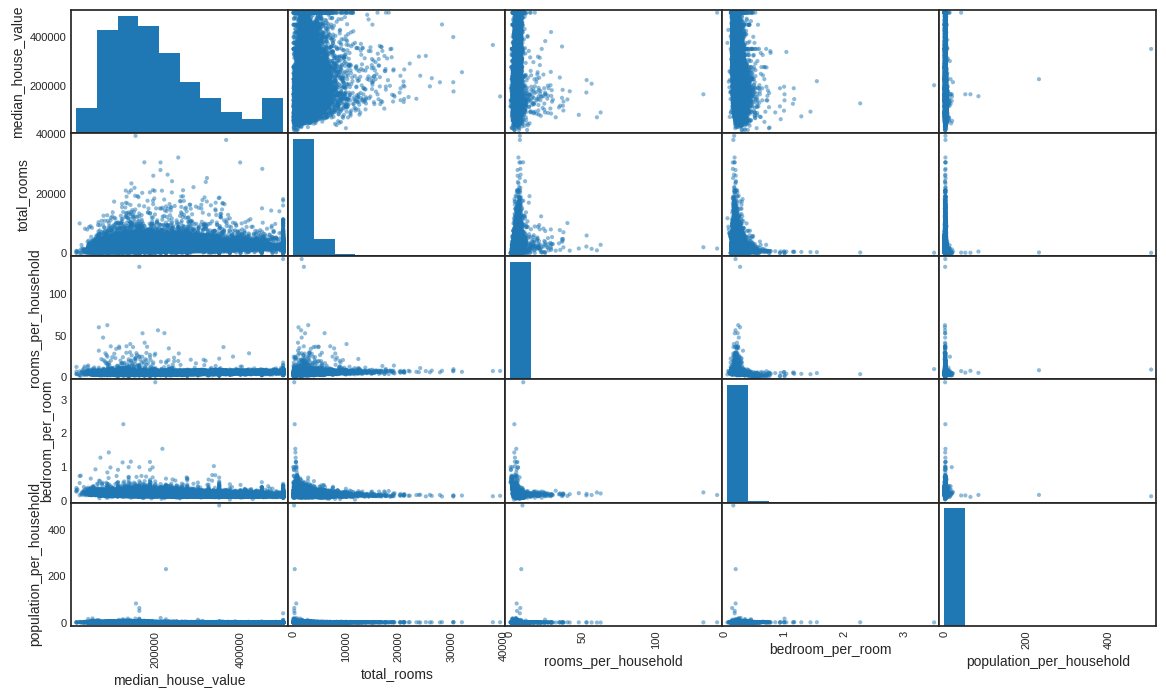

In [35]:
attributes = ['median_house_value', 'total_rooms', 'rooms_per_household', 'bedroom_per_room', 'population_per_household']
scatter_matrix(housing_num[attributes], figsize=(14,8));

## 7.3. Encoding

In [36]:
# Transformando variáveis categóricas em numéricas
# Separar apenas os atributos categóricos
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [37]:
# Atribui um valor para cada ocorrência única de ocean_proximity
# A utilização do OrdinalEncoder pode ser problemática pois, como o encoder atribui valores crescentes, o modelo de ML pode interpretar a proximidade
# de valores como indicação de que exista proximidade entre os atributos categóricos, o quê, no caso, não é correto. Outro encoding seria recomendado
oe = OrdinalEncoder()
housing_cat_encoded = oe.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [38]:
oe.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
# Utilizando OneHotEncoder
ohe = OneHotEncoder()
housing_cat_ohe = ohe.fit_transform(housing_cat)

In [40]:
housing_cat_ohe = housing_cat_ohe.toarray()
aux = pd.DataFrame(housing_cat_ohe, columns=ohe.get_feature_names_out(), index=housing_cat.index)
housing_cat = pd.concat([housing_cat, aux], axis=1)

In [41]:
housing_cat.head()

,ocean_proximity,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,NEAR BAY,0.0,0.0,0.0,1.0,0.0
14973,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
3785,INLAND,0.0,1.0,0.0,0.0,0.0
14689,INLAND,0.0,1.0,0.0,0.0,0.0
20507,NEAR OCEAN,0.0,0.0,0.0,0.0,1.0


## 7.4. Scalling

Utilizando a padronização (Standardization), os valores dos atributos são subtraídos de suas médias e divididos pelo seu desvio padrão. A ideia é centralizar os dados em zero, característica esta encontrada na distribuição normal.

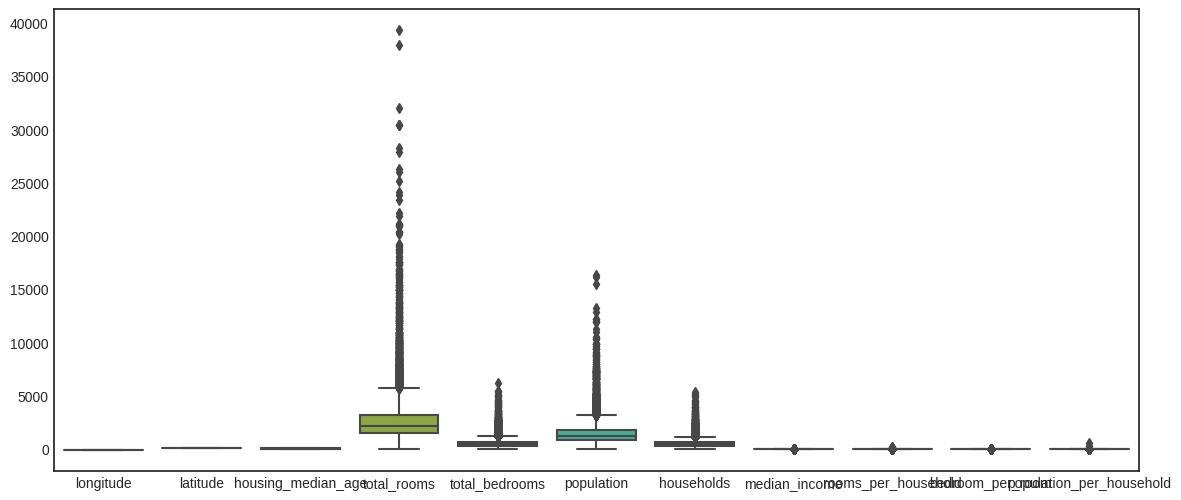

In [42]:
# Verificando as escalas dos atributos numéricos
plt.figure(figsize=(14,6))
sns.boxplot(housing_num.drop('median_house_value', axis=1));

In [43]:
# Aplicando a padronização
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [44]:
housing_num_std_scaled = pd.DataFrame(housing_num_std_scaled, columns=housing_num.columns, index=housing_num.index)

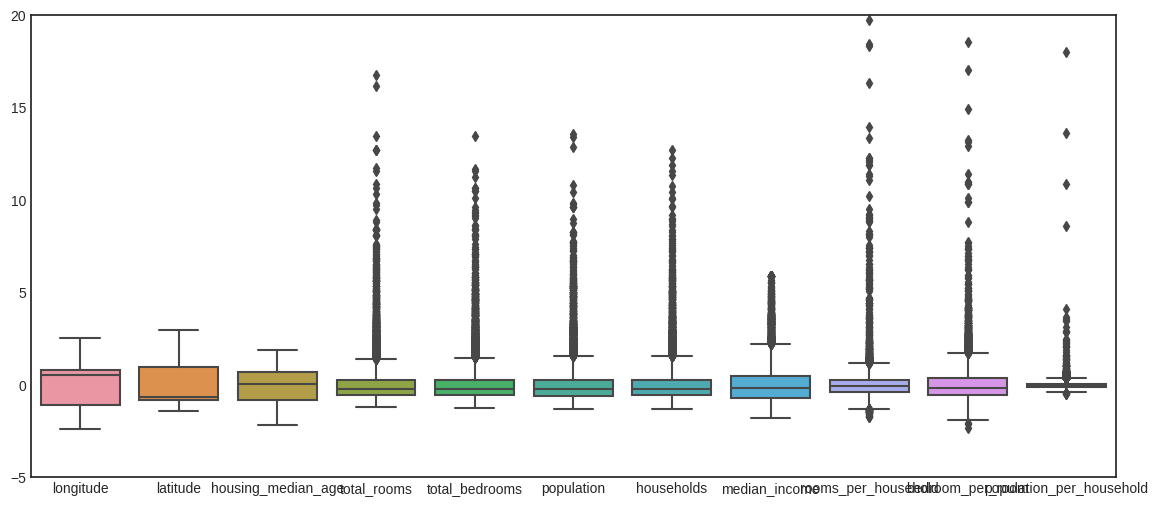

In [45]:
plt.figure(figsize=(14,6))
sns.boxplot(housing_num_std_scaled.drop('median_house_value', axis=1))
plt.ylim(-5,20);

# 8. Creating Pipeline

## 8.1. Classe para criação das novas features

In [48]:
class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    '''
    Faz a criação de novas features.
    Entrada: Numpy array 2D
    Saída: Numpy array 2D
    
    rooms_ix: índice da coluna total_rooms
    bedrooms_ix: índice da coluna total_bedrooms
    population_ix: índice da coluna population
    households_ix: índice da coluna households
    '''

    def __init__(self, rooms_ix, bedrooms_ix, population_ix, households_ix, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.rooms_ix = rooms_ix
        self.bedrooms_ix = bedrooms_ix
        self.population_ix = population_ix
        self.households_ix = households_ix

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, self.rooms_ix] / X[:, self.households_ix]
        population_per_household = X[:, self.population_ix] / X[:, self.households_ix]
        if self.add_bedrooms_per_room == True:
            bedroom_per_room = X[:, self.bedrooms_ix] / X[:, self.rooms_ix]
            return np.c_[X, rooms_per_household, bedroom_per_room, population_per_household]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

## 8.2. Pipeline para os atributos numéricos

In [49]:
num_attribs = housing.select_dtypes(exclude='object').columns.to_list()
cat_attribs = housing.select_dtypes(include='object').columns.to_list()

rooms_col=housing.columns.get_loc('total_rooms')
bedrooms_col=housing.columns.get_loc('total_bedrooms')
population_col=housing.columns.get_loc('population')
households_col=housing.columns.get_loc('households')

In [50]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                         ('attibs_adder', CombineAttributesAdder(rooms_col, bedrooms_col, population_col, households_col, add_bedrooms_per_room = True)),
                         ('std_scaler', StandardScaler())
                         ])

In [51]:
full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(), cat_attribs)],
                                   remainder='drop')

In [52]:
housing_pipeline = full_pipeline.fit_transform(housing)

In [53]:
new_derived_features = ['rooms_per_household', 'bedroom_per_room', 'population_per_household']
col_names = num_attribs+new_derived_features+full_pipeline.named_transformers_['cat'].get_feature_names_out().tolist()

In [54]:
housing_prepared = pd.DataFrame(housing_pipeline, columns=col_names, index=housing.index)

In [55]:
housing_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedroom_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.366061,0.137460,1.394812,-0.936491,2.185112,-0.866027,1.696709,-0.330204,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.438593,-0.693771,-0.373485,1.171942,2.406254,0.024550,-0.480227,-0.253616,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.763478,-0.788768,-0.775727,-0.759789,-0.907406,-0.041193,-0.197365,-0.051041,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.740005,0.383175,0.731375,-0.850281,-0.955971,-0.034858,-0.148229,-0.141475,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.593718,0.444376,1.755263,-0.180365,1.348242,-0.666554,0.880001,-0.306148,0.0,0.0,0.0,0.0,1.0


# 9. Machine Learning

## 9.1. Teste em modelo Linear

In [115]:
housing_labels = strat_train_set[['median_house_value']].copy()

In [116]:
# Teste com poucos dados
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

In [117]:
some_data_prepared = pd.DataFrame(full_pipeline.transform(some_data), columns=col_names, index=some_data.index)

In [125]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared.drop('median_house_value', axis=1), housing_labels)
y_hat_test = lin_reg.predict(some_data_prepared.drop('median_house_value', axis=1))

In [126]:
print('Predictions:', y_hat_test)

Predictions: [[275330.35884617]
 [333704.32342795]
 [118646.10818359]
 [108968.46475602]
 [308700.66411777]]


In [123]:
print('Labels:', some_labels)

Labels:        median_house_value
13096            458300.0
14973            483800.0
3785             101700.0
14689             96100.0
20507            361800.0


### 9.1.1. Verificação do RMSE

In [130]:
lin_rmse = mean_squared_error(some_labels, y_hat_test, squared=False)

print(f'RMSE: {lin_rmse:.4f}')

RMSE: 108884.2589


## 9.2. Teste em conjunto de validação sem cross-validation
- Dividir strat_train_set em treino e validação (80% treino / 20% validação)

In [85]:
# Utilizando o métido sem estratificação
train_set, validation_set = train_test_split(housing_prepared, train_size=0.8, random_state=42)

In [86]:
train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedroom_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
15718,0.591396,-0.823984,0.351428,-0.044116,-0.237022,-0.299164,-0.219379,1.108883,2.507719,0.261054,-0.585470,-0.079994,1.0,0.0,0.0,0.0,0.0
3689,-1.433034,0.994855,1.702204,-0.023065,0.071263,-0.438921,0.114952,0.730212,1.476591,-0.264880,0.074164,-0.282427,0.0,0.0,0.0,1.0,0.0
4387,0.691368,-0.852110,-1.396635,-0.808798,-0.796678,-0.916650,-0.728711,0.404874,-0.433902,-0.580913,0.256364,-0.243755,0.0,0.0,0.0,0.0,1.0
4408,0.716361,-0.692728,0.113056,-0.018947,0.517091,1.318538,0.702643,-0.915877,-0.555314,-0.801299,1.075986,0.164866,1.0,0.0,0.0,0.0,0.0
6607,1.131244,-1.161500,-0.919891,-0.428059,-0.654393,-0.588725,-0.571994,0.946188,0.156677,0.242048,-0.841348,-0.048598,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,0.281483,-0.130200,-0.363689,-0.319603,-0.130308,-0.135659,-0.169752,-1.487637,-1.341885,-0.380309,0.488034,-0.013538,0.0,1.0,0.0,0.0,0.0
19048,-1.982879,1.655825,-0.840434,-0.177741,-0.068651,-0.359451,-0.342141,-0.832944,-0.913477,0.256117,0.169166,-0.044697,1.0,0.0,0.0,0.0,0.0
1565,0.726358,-0.692728,0.113056,-0.401517,-0.291565,-0.443488,-0.266394,-0.532449,-0.153789,-0.393880,0.302497,-0.142278,1.0,0.0,0.0,0.0,0.0
18745,0.126527,0.666714,-1.078806,0.215812,0.265720,-1.050012,-1.026475,0.666518,-0.235308,9.181492,-0.073006,-0.093451,0.0,1.0,0.0,0.0,0.0


In [87]:
# Criando datasets com as features e os valores-alvo
X_train = train_set.drop('median_house_value', axis=1)
y_train = train_set[['median_house_value']].copy()
X_validation = validation_set.drop('median_house_value', axis=1)
y_validation = validation_set[['median_house_value']].copy()

In [88]:
# Instanciando um objeto
lin_reg = LinearRegression()

# Treinando o modelo
lin_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Testando em algumas instâncias
some_data = X_validation.iloc[:5]
some_labels = y_validation.iloc[:5]

# Fazendo as transformações de algumas instâncias
some_data_prepared = pd.DataFrame(full_pipeline.transform(some_data), columns=col_names, index=some_data.index)

In [71]:
print('Predictions:', lin_reg.predict(some_data_prepared))

Predictions: [[458300.]
 [483800.]
 [101700.]
 [ 96100.]
 [361800.]]


In [72]:
some_labels

,median_house_value
13096,458300.0
14973,483800.0
3785,101700.0
14689,96100.0
20507,361800.0
